In [21]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import stackstac
import pystac_client
import geopandas as gpd

In [7]:

URL = "https://earth-search.aws.element84.com/v0"
catalog = pystac_client.Client.open(URL)



In [8]:
(lat, lon) = (10.428325151352896, -85.091735052686)
roi_geometry = dict(type="Point", coordinates=[lon, lat]),

In [9]:
roi_geojson_path = "./datos/geo/nicoya.geojson"
roi_geometry = gpd.read_file(roi_geojson_path).geometry[0]

In [11]:
items = catalog.search(
    intersects=roi_geometry,
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2020-04-01/2020-05-01"
).get_all_items()


In [13]:
items

id: S2B_16PFR_20200428_0_L2A
"bbox: [-86.09018341275493, 8.953372194950143, -85.08634960136929, 9.95015470567488]"
created: 2020-09-05T08:54:16.360Z
sentinel:product_id: S2B_MSIL2A_20200428T155819_N0214_R097_T16PFR_20200428T195928
sentinel:sequence: 0
view:off_nadir: 0
sentinel:valid_cloud_cover: True
platform: sentinel-2b
sentinel:utm_zone: 16
proj:epsg: 32616
sentinel:grid_square: FR


In [12]:
len(items)

12

In [14]:
items[0]

id: S2B_16PFR_20200428_0_L2A
"bbox: [-86.09018341275493, 8.953372194950143, -85.08634960136929, 9.95015470567488]"
created: 2020-09-05T08:54:16.360Z
sentinel:product_id: S2B_MSIL2A_20200428T155819_N0214_R097_T16PFR_20200428T195928
sentinel:sequence: 0
view:off_nadir: 0
sentinel:valid_cloud_cover: True
platform: sentinel-2b
sentinel:utm_zone: 16
proj:epsg: 32616
sentinel:grid_square: FR


In [22]:
stack = stackstac.stack(items)

In [16]:
stack

<xarray.DataArray 'stackstac-5cff200252d5a0d260cbf53d712400e5' (time: 12,
                                                                band: 17,
                                                                y: 20976,
                                                                x: 10980)>
dask.array<fetch_raster_window, shape=(12, 17, 20976, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/24)
  * time                        (time) datetime64[ns] 2020-04-03T16:20:29 ......
    id                          (time) <U24 'S2A_16PFS_20200403_0_L2A' ... 'S...
  * band                        (band) <U8 'overview' 'B11' ... 'visual' 'SCL'
  * x                           (x) float64 6e+05 6e+05 ... 7.098e+05 7.098e+05
  * y                           (y) float64 1.2e+06 1.2e+06 ... 9.902e+05
    sentinel:latitude_band      <U1 'P'
    ...                          ...
    eo:cloud_cover              (time) float64 2.0 2.63 6.0 ... 54.28 75.23 54.8
    updated                     (time) <U24 '2020-08-31T18:54:27.777Z' ... '2...
    platform                    (time) <U11 'sentinel-2a' ... 'sentinel-2b'
    constellation               <U10 'sentinel-2'
    title                       (band) <U31 'True color image' ... 'Scene Cla...
    epsg                        int64 32616
Attributes:
    spec:        RasterSpec(epsg=32616, bounds=(600000.0, 990240.0, 709800.0,...
    crs:         epsg:32616
    transform:   | 10.00, 0.00, 600000.00|\n| 0.00,-10.00, 1200000.00|\n| 0.0...
    resolution:  10.0

In [23]:
lowcloud = stack[stack["eo:cloud_cover"] < 20]

In [24]:
len(lowcloud)

6

In [25]:
rgb = lowcloud.sel(band=["B04", "B03", "B02"])

In [26]:
monthly = rgb.resample(time="MS").median("time", keep_attrs=True)

In [27]:
monthly

<xarray.DataArray 'stackstac-bf035d3a7abbf84ebfe5ad0ada59c6c1' (time: 1,
                                                                band: 3,
                                                                y: 20976,
                                                                x: 10980)>
dask.array<stack, shape=(1, 3, 20976, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/15)
  * band                        (band) <U8 'B04' 'B03' 'B02'
  * x                           (x) float64 6e+05 6e+05 ... 7.098e+05 7.098e+05
  * y                           (y) float64 1.2e+06 1.2e+06 ... 9.902e+05
    sentinel:latitude_band      <U1 'P'
    instruments                 <U3 'msi'
    gsd                         int64 10
    ...                          ...
    sentinel:sequence           <U1 '0'
    sentinel:valid_cloud_cover  bool True
    constellation               <U10 'sentinel-2'
    title                       (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    epsg                        int64 32616
  * time                        (time) datetime64[ns] 2020-04-01
Attributes:
    spec:        RasterSpec(epsg=32616, bounds=(600000.0, 990240.0, 709800.0,...
    crs:         epsg:32616
    transform:   | 10.00, 0.00, 600000.00|\n| 0.00,-10.00, 1200000.00|\n| 0.0...
    resolution:  10.0

In [28]:
monthly.crs

'epsg:32616'

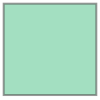

In [29]:
roi_geometry

In [31]:
import pyproj

In [33]:
transformer = pyproj.Proj(monthly.crs)

In [56]:
x_utm, y_utm = pyproj.Proj(monthly.crs)(lon, lat)
buffer = 2000  # meters

In [61]:
x_utm, y_utm 

(708893.9077437934, 1153400.0743172888)

In [37]:
monthly.crs

'epsg:32616'

In [50]:
gpd.read_file(roi_geojson_path).crs.to_string().lower()

'epsg:4326'

In [54]:
# STAC items store bounding box info in epsg:4326
from shapely.ops import transform
transformer = pyproj.Transformer.from_crs(
    crs_from=gpd.read_file(roi_geojson_path).crs.to_string().lower(),
    crs_to=monthly.crs,
    always_xy=True,
)


        

In [59]:
mask = transform(transformer.transform, roi_geometry).total_bounds

In [ ]:
# Get the UTM coordinates of the bounding box (envelope) of the square region
min_x, min_y, max_x, max_y = mask


In [62]:
aoi = monthly.loc[..., max_y:min_y, min_x:max_x]
aoi

<xarray.DataArray 'stackstac-bf035d3a7abbf84ebfe5ad0ada59c6c1' (time: 1,
                                                                band: 3,
                                                                y: 3833, x: 3851)>
dask.array<getitem, shape=(1, 3, 3833, 3851), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/15)
  * band                        (band) <U8 'B04' 'B03' 'B02'
  * x                           (x) float64 6.472e+05 6.472e+05 ... 6.857e+05
  * y                           (y) float64 1.138e+06 1.138e+06 ... 1.099e+06
    sentinel:latitude_band      <U1 'P'
    instruments                 <U3 'msi'
    gsd                         int64 10
    ...                          ...
    sentinel:sequence           <U1 '0'
    sentinel:valid_cloud_cover  bool True
    constellation               <U10 'sentinel-2'
    title                       (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    epsg                        int64 32616
  * time                        (time) datetime64[ns] 2020-04-01
Attributes:
    spec:        RasterSpec(epsg=32616, bounds=(600000.0, 990240.0, 709800.0,...
    crs:         epsg:32616
    transform:   | 10.00, 0.00, 600000.00|\n| 0.00,-10.00, 1200000.00|\n| 0.0...
    resolution:  10.0

In [63]:
import dask.diagnostics
with dask.diagnostics.ProgressBar():
    data = aoi.compute()

[########################################] | 100% Completed | 280.20 s


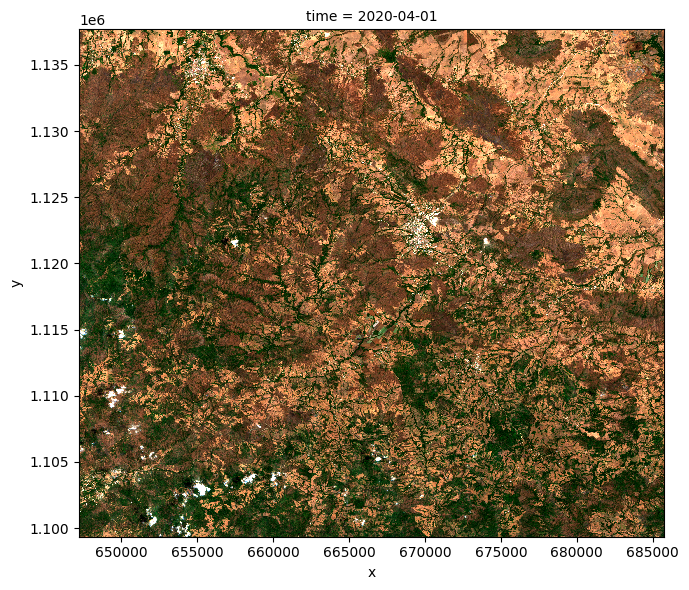

In [64]:
data.plot.imshow(row="time", rgb="band", robust=True, size=6);

In [78]:
import pickle
with open('example_stackstac.pkl', 'wb') as f:
    pickle.dump(data, f)